In [ ]:
import cv2
import torch
import urllib.request

import matplotlib.pyplot as plt
import cv2

In [92]:
from PIL import Image
import numpy as np


def depth_read(filename):
    # loads depth map D from png file
    # and returns it as a numpy array,
    # for details see readme.txt

    depth_png = np.array(Image.open(filename), dtype=int)
    # make sure we have a proper 16bit depth map here.. not 8bit!
    assert(np.max(depth_png) > 255)

    depth = depth_png.astype(np.float32) / 256.
    depth[depth_png == 0] = -1.
    return depth

In [93]:
model_type = "MiDaS_small"
midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in C:\Users\mkami/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\mkami/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master


Loading weights:  None


In [94]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.small_transform

Using cache found in C:\Users\mkami/.cache\torch\hub\intel-isl_MiDaS_master


In [122]:
# url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
# urllib.request.urlretrieve(url, filename)
picture = "D:/put-mp-2025/dataset/train/2011_09_26_drive_0001_sync/image_02/raw/0000000005.png"
depth_map = "D:/put-mp-2025/dataset/train/2011_09_26_drive_0001_sync/image_02/target/0000000005.png"

img = Image.open(picture).convert("RGB")
gt_depth = depth_read(depth_map)
img = np.array(img)

valid_mask = gt_depth > 0

In [153]:
input_tensor = transform(img)
if input_tensor.ndim == 3:
    print("a")
    input_tensor = input_tensor.unsqueeze(0)
input_tensor.to(device)

tensor([[[[-1.9335, -1.9364, -1.8884,  ..., -1.7974, -1.8194, -1.9924],
          [-1.9060, -2.0040, -1.9631,  ..., -1.9835, -1.7779, -1.9145],
          [-1.9270, -1.9462, -1.9393,  ..., -1.7813, -1.4156, -1.8906],
          ...,
          [-1.6555, -1.6309, -1.6512,  ..., -0.1018, -0.3410, -0.7157],
          [-1.6633, -1.6504, -1.5973,  ..., -0.8853, -0.8589, -0.3791],
          [-1.6528, -1.6677, -1.6787,  ..., -0.6136, -0.8823, -0.7701]],

         [[-1.7810, -1.7689, -1.7205,  ..., -1.6369, -1.7977, -1.8967],
          [-1.7289, -1.8411, -1.8720,  ..., -1.7679, -1.7907, -1.8111],
          [-1.8045, -1.7564, -1.7745,  ..., -1.1127, -1.3687, -1.7401],
          ...,
          [-1.4620, -1.4735, -1.4788,  ..., -0.5118, -1.0859, -1.0638],
          [-1.4720, -1.4806, -1.3839,  ..., -0.7058, -0.7783, -0.6141],
          [-1.4397, -1.4337, -1.4362,  ..., -0.8862, -0.8536, -0.6703]],

         [[-1.5701, -1.6042, -1.5623,  ..., -1.4840, -1.5729, -1.6936],
          [-1.4750, -1.6299, -

In [150]:
img.shape

(375, 1242, 3)

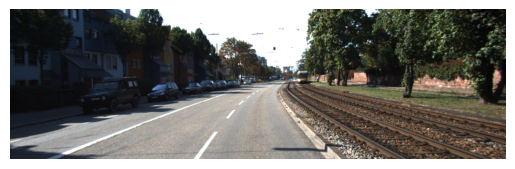

In [144]:
plt.imshow(img)
plt.axis("off")
plt.show()

In [145]:
img.shape[:2]

(375, 1242)

In [ ]:
with torch.no_grad():
    prediction = midas(input_tensor)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img_np.shape[:2],  # (H, W)
        mode="bilinear",
        align_corners=False
    ).squeeze().cpu().numpy()

In [ ]:
def scale_depth(pred, gt, mask):
    scale = np.median(gt[mask]) / np.median(pred[mask])
    return pred * scale

pred_aligned = scale_depth(prediction, gt_depth, valid_mask)


def compute_metrics(gt, pred, mask):
    thresh = np.maximum(gt[mask] / pred[mask], pred[mask] / gt[mask])
    a1 = (thresh < 1.25).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()
    abs_rel = np.mean(np.abs(gt[mask] - pred[mask]) / gt[mask])
    rmse = np.sqrt(np.mean((gt[mask] - pred[mask]) ** 2))
    log10 = np.mean(np.abs(np.log10(gt[mask]) - np.log10(pred[mask])))

    return {
        "AbsRel": abs_rel,
        "RMSE": rmse,
        "Log10": log10,
        "δ < 1.25": a1,
        "δ < 1.25^2": a2,
        "δ < 1.25^3": a3
    }

metrics = compute_metrics(gt_depth, pred_aligned, valid_mask)
print("Depth Estimation Metrics on KITTI:")
for k, v in metrics.items():
    print(f"{k:10s}: {v:.4f}")


In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_np)
plt.title("RGB Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(gt_depth, cmap="plasma", vmin=0, vmax=80)
plt.title("Ground Truth Depth")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(pred_aligned, cmap="plasma", vmin=0, vmax=80)
plt.title("MiDaS_small Prediction (scaled)")
plt.colorbar()

plt.tight_layout()
plt.show()
